**QQP_TFIDF_WORD2VEC_GN_LSTM on Quora Question Pairs**

This notebook is about implementing the LSTM model on Kaggle's Quora Question Pairs data using TFIDF weighted Word2Vec embeddings.


# CODE

First, lets import all the necessary packages

In [1]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Dense, Embedding, LSTM, Lambda, Dropout
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

Global variables

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# File paths
TRAIN_CSV = '/content/drive/MyDrive/Copy-CDS-B3/Capstone Project/Data/cleantext/bert/bctrain.csv'
TEST_CSV = '/content/drive/MyDrive/Copy-CDS-B3/Capstone Project/Data/cleantext/bert/bcdev.csv'
EMBEDDING_FILE = '/content/drive/MyDrive/Copy-CDS-B3/Capstone Project/Data/googlenews/GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = '/content/drive/MyDrive/Copy-CDS-B3/Capstone Project/Data/'

In [4]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

TF-IDF

In [5]:
trainpath = '/content/drive/MyDrive/Copy-CDS-B3/Capstone Project/Data/cleantext/cleaned_train_data.csv'
train_data1 = pd.read_csv(trainpath, delimiter=",", encoding='utf-8')

In [6]:
train_data = train_data1.sample(frac=1)
questions = list(train_data['question1'].astype('str')) + list(train_data['question2'].astype('str'))

In [7]:
tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

Create embedding matrix

In [8]:
# Google News Word2Vec vectors
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [9]:
# Prepare embedding
vocabularyq = dict()
inverse_vocabularyq = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
questions_cols = ['question1', 'question2']

# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

#stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' convert text to a list of words '''
    text = str(text)
    text = text.lower()
    text = text.split()
    return text

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word not in word2vec.vocab:
                    continue

                if word not in vocabularyq:
                    vocabularyq[word] = len(inverse_vocabularyq)
                    q2n.append(len(inverse_vocabularyq))
                    inverse_vocabularyq.append(word)
                else:
                    q2n.append(vocabularyq[word])

            # Replace questions as word to question as number representation
            dataset.at[index, question] = q2n

In [10]:
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabularyq) + 1, embedding_dim)  # This is the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word1, inx in vocabularyq.items():
    if word1 in word2vec.vocab and word1 in word2tfidf.keys():
        embeddings[inx] = word2vec.word_vec(word1) * word2tfidf[word1]
    elif word1 in word2vec.vocab:
        embeddings[inx] = word2vec.word_vec(word1)

In [11]:
import gc
del(word2vec)
del(word2tfidf)
del(train_data1)
del(questions)
gc.collect()

356

Prepare training and validation data

In [12]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [13]:
Y_test = test_df['is_duplicate']
for dataset, side in itertools.product([X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

Y_test.shape, X_test['left'].shape, X_test['right'].shape, len(X_test['right'])

((40430,), (40430, 216), (40430, 216), 40430)

Build the model

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = metrics.confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    B =(C/C.sum(axis=0))
    #divide each element of the confusion matrix with the sum of elements in that row
    
    plt.figure(figsize=(20,4))
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [17]:
def print_modelpred_metrics(y_test,y_pred):
    prediction = np.round(abs(y_pred))
    print ('Accuracy:  ', accuracy_score(y_test, prediction))
    print ('F1 score:  ', f1_score(y_test, prediction))
    print ('Recall:    ', recall_score(y_test, prediction))
    print ('Precision: ', precision_score(y_test, prediction))
    print ('\nclasification report:\n\n', classification_report(y_test,prediction))
    print ('\n confusion matrix:\n\n',confusion_matrix(y_test, prediction))

In [16]:
# Model variables
n_lstm = 100
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 20

import tensorflow as tf

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_lstm)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)
concat_outputs = tf.concat([left_output, right_output, tf.abs(left_output - right_output)], axis=1)
outputs = Dense(64, activation='relu')(concat_outputs)
outputs = Dense(32, activation='relu')(outputs)
prob = Dense(1, activation='sigmoid')(outputs)


# Adam optimizer
optimizer = Adam(learning_rate=0.001)

qqplstm = Model([left_input, right_input], prob)

qqplstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Start training
training_start_time = time()

from keras.callbacks import EarlyStopping

early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, verbose=0, mode='auto')

qqplstm_trained = qqplstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch, callbacks=[early],
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/20
5061/5061 [==============================] - 135s 24ms/step - loss: 0.4212 - accuracy: 0.7970 - val_loss: 0.3853 - val_accuracy: 0.8183
Epoch 2/20
5061/5061 [==============================] - 119s 24ms/step - loss: 0.3510 - accuracy: 0.8386 - val_loss: 0.3624 - val_accuracy: 0.8306
Epoch 3/20
5061/5061 [==============================] - 119s 24ms/step - loss: 0.3141 - accuracy: 0.8590 - val_loss: 0.3561 - val_accuracy: 0.8399
Epoch 4/20
5061/5061 [==============================] - 120s 24ms/step - loss: 0.2862 - accuracy: 0.8729 - val_loss: 0.3578 - val_accuracy: 0.8407
Epoch 5/20
5061/5061 [==============================] - 123s 24ms/step - loss: 0.2634 - accuracy: 0.8851 - val_loss: 0.3635 - val_accuracy: 0.8400
Epoch 6/20
5061/5061 [==============================] - 123s 24ms/step - loss: 0.2440 - accuracy: 0.8947 - val_loss: 0.3595 - val_accuracy: 0.8446
Epoch 7/20
5061/5061 [==============================] - 123s 24ms/step - loss: 0.2263 - accuracy: 0.9033 - val_loss: 0

In [18]:
y_pred1 = qqplstm.predict([X_test['left'], X_test['right']])

In [19]:
prediction1 = np.round(abs(y_pred1))
print_modelpred_metrics(Y_test,prediction1)

Accuracy:   0.8411328221617611
F1 score:   0.7866467364225211
Recall:     0.795498824319785
Precision:  0.7779894875164257

clasification report:

               precision    recall  f1-score   support

           0       0.88      0.87      0.87     25545
           1       0.78      0.80      0.79     14885

    accuracy                           0.84     40430
   macro avg       0.83      0.83      0.83     40430
weighted avg       0.84      0.84      0.84     40430


 confusion matrix:

 [[22166  3379]
 [ 3044 11841]]


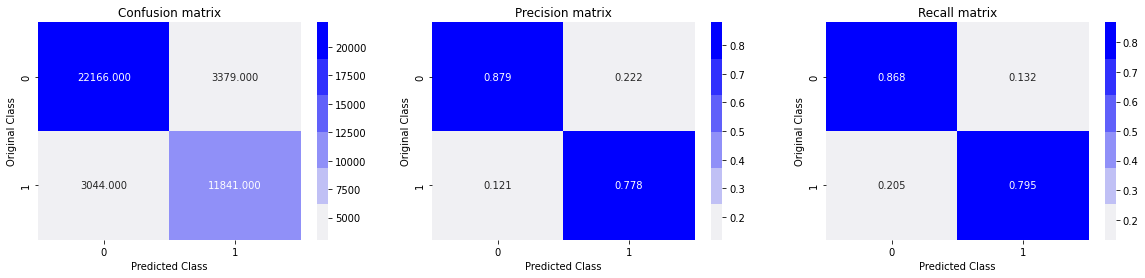

In [20]:
plot_confusion_matrix(Y_test, prediction1)

In [22]:
test1_df = pd.read_csv(TEST_CSV)

In [32]:
y_test1 = pd.DataFrame(data=test1_df.is_duplicate)
y_test1['pred_prob'] = y_pred1
y_test1['rounded_pred'] = prediction1
mergedf = pd.merge(test1_df[['question1','question2']], y_test1, left_index = True, right_index = True)
mergedf.to_csv('qqp_tfidf_word2vec_lstm_predicted_output.csv')

In [ ]:
# Model variables
n_lstm = 128
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 20

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_lstm)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)
concat_outputs = tf.concat([left_output, right_output, tf.abs(left_output - right_output)], axis=1)

outputs = Dense(128, activation='relu')(concat_outputs)
outputs = Dropout(0.2)(outputs)

outputs = Dense(64, activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)

prob = Dense(1, activation='sigmoid')(outputs)


# Adam optimizer
optimizer = Adam(learning_rate=0.001)

qqplstm1 = Model([left_input, right_input], prob)

qqplstm1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Start training
training_start_time = time()

early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, verbose=0, mode='auto')

qqplstm1_trained = qqplstm1.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch, callbacks=[early],
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/20
4429/4429 [==============================] - 135s 29ms/step - loss: 0.4315 - accuracy: 0.7922 - val_loss: 0.3868 - val_accuracy: 0.8169
Epoch 2/20
4429/4429 [==============================] - 122s 28ms/step - loss: 0.3558 - accuracy: 0.8364 - val_loss: 0.3642 - val_accuracy: 0.8300
Epoch 3/20
4429/4429 [==============================] - 124s 28ms/step - loss: 0.3150 - accuracy: 0.8584 - val_loss: 0.3666 - val_accuracy: 0.8297
Epoch 4/20
4429/4429 [==============================] - 124s 28ms/step - loss: 0.2839 - accuracy: 0.8749 - val_loss: 0.3599 - val_accuracy: 0.8351
Epoch 5/20
4429/4429 [==============================] - 122s 28ms/step - loss: 0.2567 - accuracy: 0.8881 - val_loss: 0.3698 - val_accuracy: 0.8369
Epoch 6/20
4429/4429 [==============================] - 121s 27ms/step - loss: 0.2322 - accuracy: 0.9005 - val_loss: 0.3677 - val_accuracy: 0.8436
Epoch 7/20
4429/4429 [==============================] - 123s 28ms/step - loss: 0.2133 - accuracy: 0.9096 - val_loss: 0

In [ ]:
y_pred2 = qqplstm1.predict([X_test['left'], X_test['right']])

print_modelpred_metrics(Y_test,y_pred2)

Accuracy:   0.8400633216666461
F1 score:   0.7880694854146182
Recall:     0.8023492508425936
Precision:  0.7742891186036776

clasification report:

               precision    recall  f1-score   support

           0       0.88      0.86      0.87     50890
           1       0.77      0.80      0.79     29967

    accuracy                           0.84     80857
   macro avg       0.83      0.83      0.83     80857
weighted avg       0.84      0.84      0.84     80857


 confussion matrix:

 [[43881  7009]
 [ 5923 24044]]


In [ ]:
# Model variables
n_lstm = 256
batch_size = 64
n_epoch = 20

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_lstm)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)
concat_outputs = tf.concat([left_output, right_output, tf.abs(left_output - right_output)], axis=1)

outputs = Dense(256, activation='relu')(concat_outputs)
outputs = Dropout(0.2)(outputs)

outputs = Dense(128, activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)

prob = Dense(1, activation='sigmoid')(outputs)


# Adam optimizer
optimizer = Adam(learning_rate=0.001)

qqplstm2 = Model([left_input, right_input], prob)

qqplstm2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Start training
training_start_time = time()

early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, verbose=0, mode='auto')

qqplstm2_trained = qqplstm2.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch, callbacks=[early],
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/20
4429/4429 [==============================] - 206s 46ms/step - loss: 0.4212 - accuracy: 0.7974 - val_loss: 0.3772 - val_accuracy: 0.8237
Epoch 2/20
4429/4429 [==============================] - 202s 46ms/step - loss: 0.3385 - accuracy: 0.8465 - val_loss: 0.3518 - val_accuracy: 0.8407
Epoch 3/20
4429/4429 [==============================] - 201s 45ms/step - loss: 0.2876 - accuracy: 0.8732 - val_loss: 0.3471 - val_accuracy: 0.8453
Epoch 4/20
4429/4429 [==============================] - 201s 45ms/step - loss: 0.2432 - accuracy: 0.8953 - val_loss: 0.3661 - val_accuracy: 0.8475
Epoch 5/20
4429/4429 [==============================] - 202s 46ms/step - loss: 0.2090 - accuracy: 0.9120 - val_loss: 0.3659 - val_accuracy: 0.8421
Epoch 6/20
4429/4429 [==============================] - 203s 46ms/step - loss: 0.1795 - accuracy: 0.9259 - val_loss: 0.4116 - val_accuracy: 0.8493
Epoch 7/20
4429/4429 [==============================] - 203s 46ms/step - loss: 0.1566 - accuracy: 0.9363 - val_loss: 0

In [ ]:
y_pred3 = qqplstm2.predict([X_test['left'], X_test['right']])

print_modelpred_metrics(Y_test,y_pred3)

Accuracy:   0.8473601543465624
F1 score:   0.792389987888575
Recall:     0.7859645610171189
Precision:  0.7989213391675994

clasification report:

               precision    recall  f1-score   support

           0       0.88      0.88      0.88     50890
           1       0.80      0.79      0.79     29967

    accuracy                           0.85     80857
   macro avg       0.84      0.83      0.84     80857
weighted avg       0.85      0.85      0.85     80857


 confussion matrix:

 [[44962  5928]
 [ 6414 23553]]
